In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
# np.seterr(divide='ignore') # these warnings are usually harmless for this code
# np.random.seed(0)
from matplotlib import pyplot as plt
import matplotlib
import os
matplotlib.rcParams['font.size'] = 12
plt.rcParams.update({'figure.figsize':[18,6]})

import sys
import pyhsmm
import pyhsmm.basic.distributions as distributions

sys.path.append('/home/kirilman/Projects/nir/main nir')
import myutils
import sequence_generator as generator
from HMMClassifier import SignalManager
import pomegranate as pg
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.general import rle
from myutils import plot_signal_label
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import logistic
from time import time

/home/kirilman/anaconda3/lib/python3.7/site-packages/pybasicbayes-0.2.4-py3.7-linux-x86_64.egg/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/home/kirilman/anaconda3/lib/python3.7/site-packages/pybasicbayes-0.2.4-py3.7-linux-x86_64.egg/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


ModuleNotFoundError: No module named 'myutils'

In [19]:
# np.random.seed(42)

In [20]:
def abnormals_insert(signal,size = 40):
    t = signal.copy()
    start = np.random.randint(0,len(signal) - size,)
    m = np.random.uniform(min(signal),max(signal))
    sigma = 0.3
    t[start:start+size] = np.random.normal(m,sigma,size)
    return t

from multiprocessing import Pool
def do_log_likelihood(args):
    model, data = args
    ll = []
    for x in data:
        ll += [model.log_likelihood(x.reshape(-1,1))]
    return np.array(ll)

Конструктор


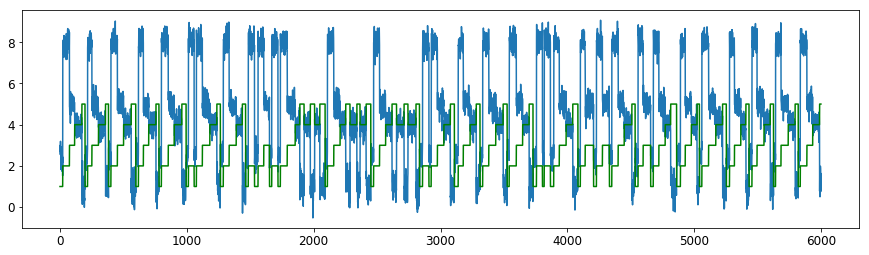

In [21]:
dur_distns = []

trans_matrix = np.array([[0.99, 0.01, 0.0, 0.0, 0.0],
                         [0.02,  0.9,  0.08, 0.0, 0.0],
                         [0.02, 0.0,  0.85, 0.13, 0.0],
                         [0.0,  0.0,  0.0, 0.9, 0.1],
                         [0.08,  0.0,  0.0, 0.02, 0.9]])

Nmax = 5
#     L = 5
#     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
#                     'K':L,
#                      'alphav_0':np.zeros(L)+0.1, 
#                      'alpha_mf':np.zeros(L)+0.1,
#                     }
obs_distns = []
#{1}
obs_hypparams = {'mu':np.array([[2.5]]),
                'sigma':np.array([[0.35**2]]),
                'kappa_0':0.3,
                'nu_0':2}
obs_distns +=[distributions.Gaussian(**obs_hypparams)]
#{2}
obs_hypparams = {'mu':np.array([[8]]),
                'sigma':np.array([[0.35**2]]),
                'kappa_0':0.3,
                'nu_0':2}
obs_distns +=[distributions.Gaussian(**obs_hypparams)]
#{3}
obs_hypparams = {'mu':np.array([[5]]),
                'sigma':np.array([[0.35**2]]),
                'kappa_0':0.3,
                'nu_0':2}
obs_distns +=[distributions.Gaussian(**obs_hypparams)]
#{4}
obs_hypparams = {'mu':np.array([[4]]),
                'sigma':np.array([[0.35**2]]),
                'kappa_0':0.3,
                'nu_0':2}
obs_distns +=[distributions.Gaussian(**obs_hypparams)]
#{5}
obs_hypparams = {'mu':np.array([[1]]),
                'sigma':np.array([[0.5**2]]),
                'kappa_0':0.3,
                'nu_0':2}

obs_distns +=[distributions.Gaussian(**obs_hypparams)]

dur_hypparams = {'lmbda': 20,
                 'alpha_0':1,
                 'beta_0':1}
dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

dur_hypparams = {'lmbda': 45,
                 'alpha_0':1,
                 'beta_0':1}
dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

dur_hypparams = {'lmbda': 50,
                 'alpha_0':1,
                 'beta_0':1}
dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

dur_hypparams = {'lmbda':50,
                 'alpha_0':1,
                 'beta_0':1}
dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

dur_hypparams = {'lmbda':30,
                 'alpha_0':1,
                 'beta_0':1}

dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

#     posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
#             alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
#             init_state_concentration=6., # pretty inconsequential
#             obs_distns=obs_distns,
#             dur_distns=dur_distns)

model = pyhsmm.models.HSMM(
        alpha=0., # На что влияет 
#             gamma=2., # better to sample over these; see concentration-resampling.py
#         init_state_concentration=., # pretty inconsequential
        obs_distns=obs_distns,
        dur_distns=dur_distns,trans_matrix = trans_matrix,
        pi_0 = np.array([1.00, 0.00, 0.0, 0.0, 0.0]))
# model.resample_model()
# model.init_state_distn.pi_0 = [0.99, 0.01, 0.0 ]
# print(model.init_state_distn.pi_0)
# posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
fig = plt.figure(figsize=(15,4))
signal, stateseq = model.generate(6000)
plt.plot(signal)
plt.plot(stateseq+1,'g')

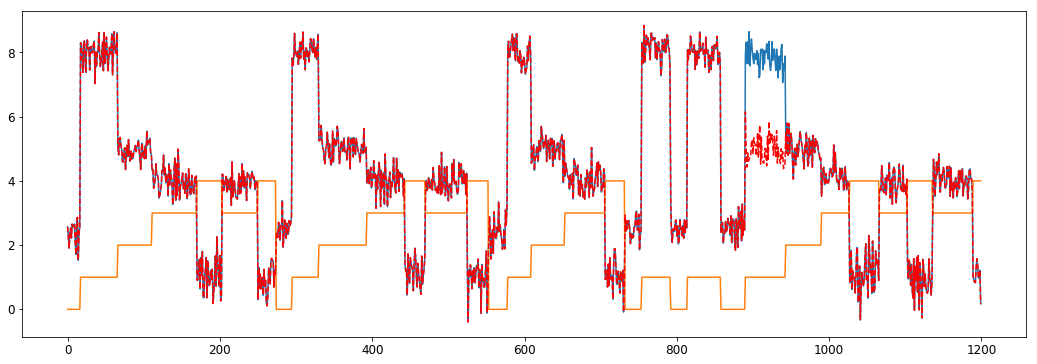

In [22]:
signal_generator = generator.Sequence(1200,type='model', hsmm_model = model)
s = signal_generator.sequence
p = signal_generator.stateseq
plt.plot(s)
plt.plot(p)
an_signal = signal_generator.get_abnormal(dtype='chain_violation',state = 1, state_update=2)
plt.plot(an_signal,'r--')

## Определяем модель и обучаем

In [23]:
#fit model
def create_model(data, Nmax):
    obs_dim = 1
    dur_distns = []
    Nmax = 7
#     L = 5
#     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
#                     'K':L,
#                      'alphav_0':np.zeros(L)+0.1, 
#                      'alpha_mf':np.zeros(L)+0.1,
#                     }

    obs_hypparams = {'mu_0':np.zeros(obs_dim),
                    'sigma_0':np.eye(obs_dim),
                    'kappa_0':2,
                    'nu_0':obs_dim+5}
    obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]

    
    dur_hypparams = {'alpha_0':45,
                     'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':20,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':30,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':55,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    
    
    dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

    posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
            alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
            init_state_concentration=6., # pretty inconsequential
            obs_distns=obs_distns,
            dur_distns=dur_distns)

#     posteriormodel = pyhsmm.models.HSMM(
#             alpha=6., # На что влияет 
# #             gamma=2., # better to sample over these; see concentration-resampling.py
#             init_state_concentration=6., # pretty inconsequential
#             obs_distns=obs_distns,
#             dur_distns=dur_distns)
    
    posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
    
    fig = plt.figure(figsize=(12,10),dpi = 140)
    for idx in progprint_xrange(150):
        posteriormodel.resample_model(1)
    plt.show()
    return posteriormodel

In [24]:
from multiprocessing import Pool
class hsmm_classifier():
    def __init__(self, N = 5):
        self.models = []
        self.number_model = N
        
    def fit(self,data):
        pool = Pool(4)
        params = [ (data, i + 10) for i in range(self.number_model)]
        self.models = pool.starmap(self.create_model, params)
        pool.close()
        pool.join()
    def log_likelihood(self, data):
#         pool = Pool(self.number_model)
#         return pool(self.models.log_likelihood, [(data,)*self.number_model])
        return np.array([m.log_likelihood(data) for m in self.models])
    
    def test(self):
        for m in self.models:
            print(m.generate(10,1))
            
    def create_model(self,data,seed):
        np.random.seed(seed)
        obs_dim = 1
        dur_distns = []
        Nmax = 7
    #     L = 5
    #     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
    #                     'K':L,
    #                      'alphav_0':np.zeros(L)+0.1, 
    #                      'alpha_mf':np.zeros(L)+0.1,
    #                     }

        obs_hypparams = {'mu_0':np.zeros(obs_dim),
                        'sigma_0':np.eye(obs_dim),
                        'kappa_0':2,
                        'nu_0':obs_dim+5}
        obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]


        dur_hypparams = {'alpha_0':45,
                         'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':20,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':30,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':55,
    #                      'beta_0':1}
#         dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

#         dur_distns = [distributions.GeometricDuration(**dur_hypparams) for state in range(Nmax)]

        dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

        posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
                alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
                init_state_concentration=6., # pretty inconsequential
                obs_distns=obs_distns,
                dur_distns=dur_distns)

    #     posteriormodel = pyhsmm.models.HSMM(
    #             alpha=6., # На что влияет 
    # #             gamma=2., # better to sample over these; see concentration-resampling.py
    #             init_state_concentration=6., # pretty inconsequential
    #             obs_distns=obs_distns,
    #             dur_distns=dur_distns)

        posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
        for idx in progprint_xrange(150):
            posteriormodel.resample_model(1)
        return posteriormodel
    def get_models(self):
        return self.models

In [25]:
classifiear = hsmm_classifier(N = 4)
classifiear.fit(signal.reshape(-1,1))

Конструктор
Конструктор
Конструктор
Конструктор


/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


.................................................................................................  [  25/150,   10.66sec avg, ETA 22:13 ]
.  [  25/150,   10.74sec avg, ETA 22:23 ]
.  [  25/150,   10.75sec avg, ETA 22:23 ]
.  [  25/150,   10.88sec avg, ETA 22:40 ]
.................................................................................................  [  50/150,   10.66sec avg, ETA 17:46 ]
.  [  50/150,   10.68sec avg, ETA 17:48 ]
.  [  50/150,   10.69sec avg, ETA 17:49 ]
.  [  50/150,   10.74sec avg, ETA 17:54 ]
.................................................................................................  [  75/150,   10.44sec avg, ETA 13:03 ]
.  [  75/150,   10.46sec avg, ETA 13:05 ]
.  [  75/150,   10.49sec avg, ETA 13:06 ]
.  [  75/150,   10.52sec avg, ETA 13:09 ]
.................................................................................................  [ 100/150,   10.38sec avg, ETA 08:39 ]
.  [ 100/150,   10.38sec avg, ETA 08:39 ]
.  [ 100/150,   10.38sec avg

### Генерация тестовых данных {400}

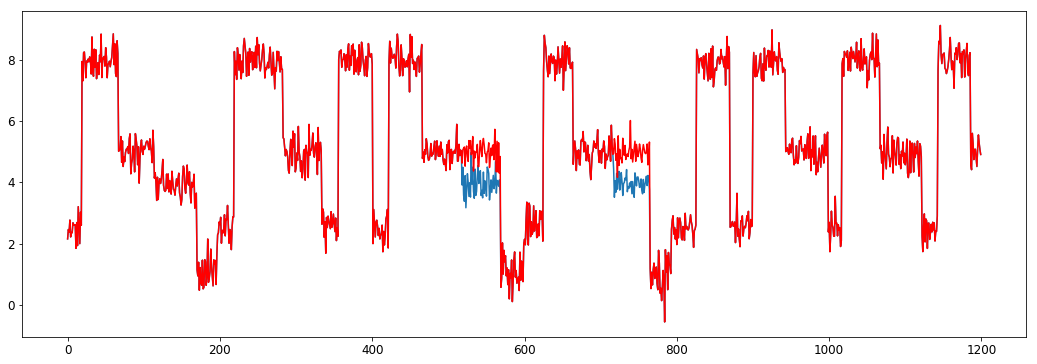

In [26]:
T = 1200
signal_generator = generator.Sequence(T,type='model', hsmm_model = model)
signal = signal_generator.sequence
an_signal = signal_generator.get_abnormal(dtype='chain_violation',state = 3, state_update=np.random.choice([0,1,2]),
                                          count_segment=2)
# an_signal = signal_generator.get_abnormal(dtype='varience',state=[1],varience_coef = 3)

an_signal = an_signal.reshape(-1,1)

plt.plot(signal)
plt.plot(an_signal,'r')

800 1200


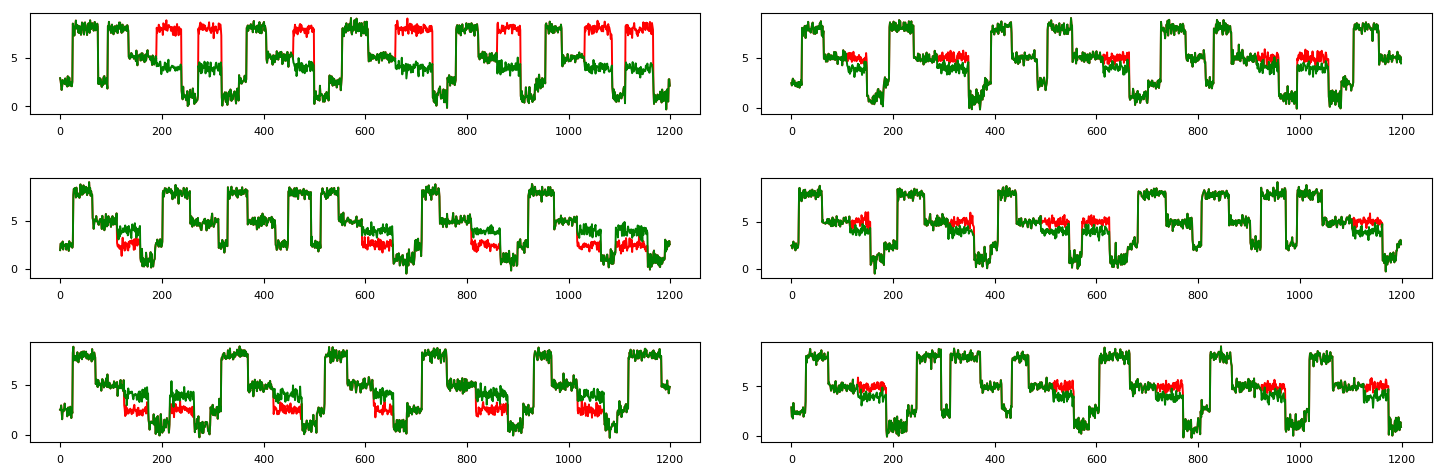

In [41]:
x_test = []
M = 400
# signal_manager.generators[0].n = T
T = 1200
y_true = np.array([0]*M+[1]*M)
# for i in range(M):
#     x_test +=[model.generate(T)[0].reshape(-1,1)]
    
normal_signal = []
abnormal_signal = []
for i in range(M):
    signal_generator = generator.Sequence(T,type='model', hsmm_model = model)
    an_signal = signal_generator.get_abnormal(dtype='chain_violation',state = 3, 
                                              state_update=np.random.choice([0,1,2]), count_segment=15)
#     an_signal[np.random.randint(0,1200)] = 11
    normal_signal +=[np.array(signal_generator.sequence).reshape(-1,1)]
    abnormal_signal +=[an_signal.reshape(-1,1)]
#     x_test+=[an_signal.reshape(-1,1)]
x_test = normal_signal + abnormal_signal    

print(len(x_test),len(x_test[0]))
#Графики сигналов
fig = plt.figure(figsize=(15,10), dpi = 100)
for i,(x,y) in enumerate(zip(x_test,x_test[M:M+6])):
    ax = plt.subplot(6,2,i+1)
    plt.plot(y,'r')
    plt.plot(x,'g')
plt.tight_layout()

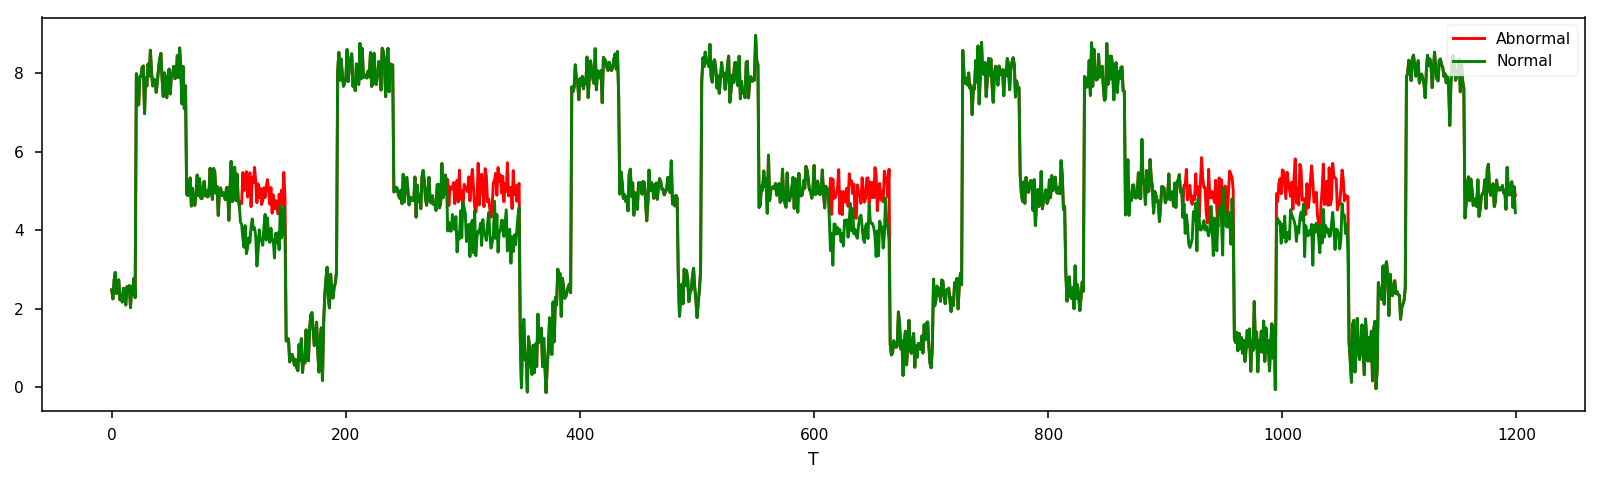

In [47]:
plt.figure(figsize=(12,4),dpi = 140)
plt.plot(x_test[M+1],'r',label='Abnormal',linewidth=1.5)
plt.plot(x_test[1],'g',label='Normal',linewidth=1.5)

plt.xlabel('T')
plt.tight_layout()
plt.legend(loc=1)
plt.savefig('Normal_abnormal_signal.jpeg',dpi=200,quality = 100)

In [43]:
%%time
pool = Pool()
x_test = np.array(x_test)

ll = pool.map(do_log_likelihood, [ (m, x_test) for m in classifiear.models])

pool.close()
pool.join()

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


CPU times: user 332 ms, sys: 164 ms, total: 496 ms
Wall time: 6min 26s


/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


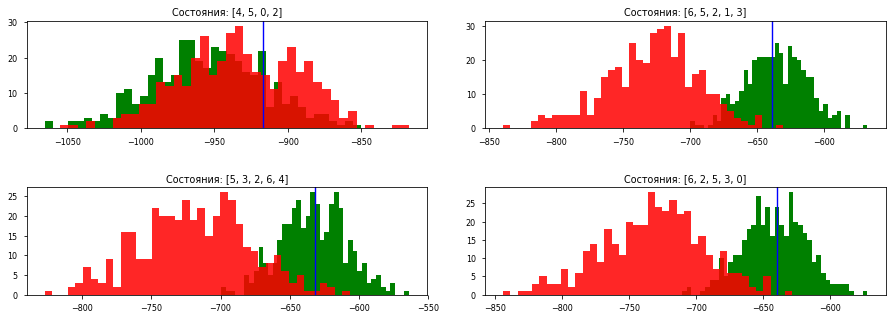

In [44]:
ll_normal = classifiear.log_likelihood(signal[:1200].reshape(-1,1))
fig = plt.figure(figsize=(13,5))
for i in range(classifiear.number_model):
    plt.subplot(2,int(classifiear.number_model/2),i+1)
#     plt.subplot(2,int(classifiear.number_model),i+1)
    plt.hist(ll[i][:M],40, color = 'green')
    plt.title('Состояния: {}'.format(classifiear.models[i].used_states))
    plt.hist(ll[i][M:],40, color = 'red', alpha = 0.85)
    plt.axvline(ll_normal[i],color='blue')
plt.tight_layout()

In [57]:
s,p = classifiear.models[6].generate(1200)
plt.plot(signal[:1200])
plt.plot(s)
plt.plot(p)

IndexError: list index out of range

In [85]:
print('ll train: {} , test: {}'.format(classifiear.models[1].log_likelihood(x_test[0].reshape(-1,1)),
                                       classifiear.models[1].log_likelihood(abnormal)))

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


NameError: name 'abnormal' is not defined

In [86]:
print(np.argmax(ll_normal))
print(ll_normal)

0
[-628.42883255 -954.15058244]


In [87]:
for i,m in enumerate(classifiear.models):
    print(m.used_states)
    print(m.num_states)
    print('model {}:\n'.format(i))
#     plt.plot(m.durations[0])
#     m.plot_duration()
    used_states = m.used_states
    for k,dist in enumerate(m.obs_distns):
        if k in used_states:
            print('Used***Состояние: {} , {}'.format(k,dist.params))
        else:
            print('Состояние: {} , {}'.format(k,dist.params))
#     print(m.obs_distns[0].params)

[1, 3, 4, 5, 2]
7
model 0:

Состояние: 0 , {'mu': array([0.01438679]), 'sigma': array([[0.27107414]])}
Used***Состояние: 1 , {'mu': array([2.46037185]), 'sigma': array([[0.1460042]])}
Used***Состояние: 2 , {'mu': array([0.96820211]), 'sigma': array([[0.2699939]])}
Used***Состояние: 3 , {'mu': array([8.00057131]), 'sigma': array([[0.1887037]])}
Used***Состояние: 4 , {'mu': array([4.98036733]), 'sigma': array([[0.16903658]])}
Used***Состояние: 5 , {'mu': array([3.99748522]), 'sigma': array([[0.15362393]])}
Состояние: 6 , {'mu': array([-0.06376032]), 'sigma': array([[0.14547392]])}
[6, 1, 2, 3]
7
model 1:

Состояние: 0 , {'mu': array([0.77231621]), 'sigma': array([[0.23605836]])}
Used***Состояние: 1 , {'mu': array([7.98988388]), 'sigma': array([[0.20658237]])}
Used***Состояние: 2 , {'mu': array([4.5067695]), 'sigma': array([[0.38728266]])}
Used***Состояние: 3 , {'mu': array([0.98553011]), 'sigma': array([[0.26160371]])}
Состояние: 4 , {'mu': array([-0.3425838]), 'sigma': array([[0.0924630

In [88]:
classifiear.models[7].trans_distn.trans_matrix

IndexError: list index out of range

In [89]:
for row in classifiear.models[7].states_list[0].trans_matrix:
    for el in row:
        print('{:f}'.format(el),end=' ')
    print()
print()
for row in classifiear.models[0].states_list[0].trans_matrix:
    for el in row:
        print('{:f}'.format(el),end=' ')
    print()

IndexError: list index out of range

In [90]:
def score(model, x_test, y_test, log_prob_normal ,train_signal,num_plot,lvl = 0.1, signal_for_lvl = None, 
          degree_std = 3):
    
    x_test = np.array(x_test)
    log_scores = []
    anomals = []
    if signal_for_lvl is None:
        low = log_prob_normal*(1-lvl)
        high = log_prob_normal*(1+lvl)
        if log_prob_normal<0:
            low, high = high, low
    else:
        ll = np.array([model.log_likelihood( np.array(s).reshape(-1,1)) for s in signal_for_lvl])
        mean, std = norm.fit(ll)
        low = mean - degree_std*std
        high = log_prob_normal + 5*std
        print('mean = {}, std = {}'.format(mean, std))
        
    print('Нижний порог {}, верхний порог {}'.format(low, high))
    y_pred = np.zeros(shape=(len(x_test),),dtype=np.int)
    
    start_time = time()
    for k,x in enumerate(x_test):
        p = model.log_likelihood(x.reshape(-1,1))
        if k == 1:
            print(p)
        log_scores+=[p]
        if p<low:
            anomals+=[x]
            y_pred[k] = 1
    log_scores = np.array(log_scores)
    print('Время для log-like: ', time() - start_time)
    print(len(anomals))
    print('Y_pred ', y_pred.sum())
    
#     return log_scores, y_pred
    f_score = f1_score(y_test, y_pred)

#Гистограмма ll
    #для нормальный
    plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
    fig = plt.figure(dpi = 90, figsize=(12,6))
    plt.hist(log_scores[y_test == 0],int(x_test.shape[0]/8),rwidth = 0.9, color='green');
    plt.axvline(x=log_prob_normal)
    plt.axvline(low,color='black')
    plt.ylabel('N')
    plt.xlabel('Log-likelihood')
    #для аномальных
    plt.hist(log_scores[y_test == 1],int(x_test.shape[0]/8),color = 'r',alpha = 0.8, rwidth = 0.9);
    plt.savefig('Гистограмма.jpeg', dpi = 150);
    
    fig = plt.figure(figsize=(18,5*num_plot))
#     plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12)
    for i in range(num_plot):
        ax = plt.subplot(num_plot, 1, i+1)
        plt.plot(train_signal,'g')
        k = np.random.choice(len(anomals))
        plt.plot(anomals[k],'r--');
    # plt.tight_layout()
    plt.savefig('Как аномальные.jpeg',dpi = 80)
#     print('x_test',x_test.shape)
#     print('index',np.where(y_pred == 0))    
#     print('y_pred',y_pred.shape)
#     print(x_test[np.where(y_pred == 0)])    
#     print(x_test[np.where(y_pred == 0)].shape)    

    fig = plt.figure(figsize=(18,5*num_plot))
    plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12)
    
    normals = x_test[y_pred == 0]
    
    print('normals',normals.shape)
    for i in range(num_plot):
        ax = plt.subplot(num_plot, 1, i+1)
        plt.plot(train_signal,'g');
        k = np.random.choice(len(normals))
        plt.plot(normals[k],'r--');
    # plt.tight_layout()
    plt.savefig('Как нормальные.jpeg',dpi = 80)
    return log_scores, y_pred,low

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


mean = -259.1778349338598, std = 11.509801667698971
Нижний порог -282.19743826925776, верхний порог -228.0239947969937
-240.09121731380714
Время для log-like:  99.04972338676453
217
Y_pred  217
normals (183, 1200)
CPU times: user 1min 42s, sys: 63.2 ms, total: 1min 42s
Wall time: 1min 42s


/home/kirilman/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


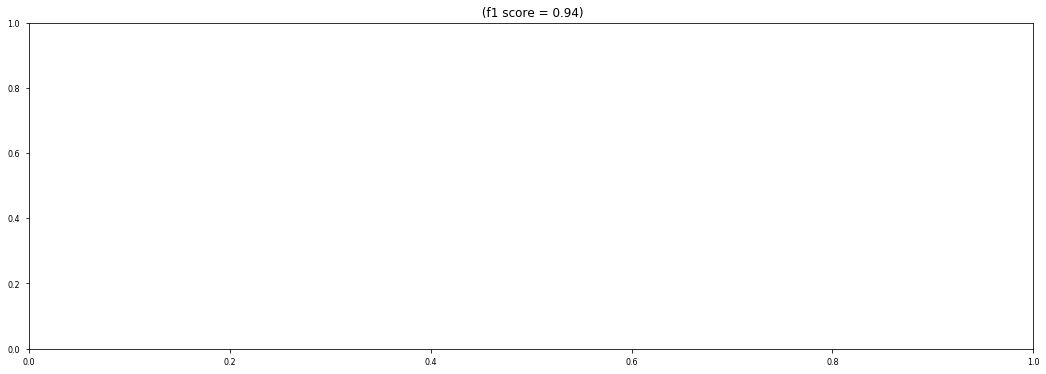

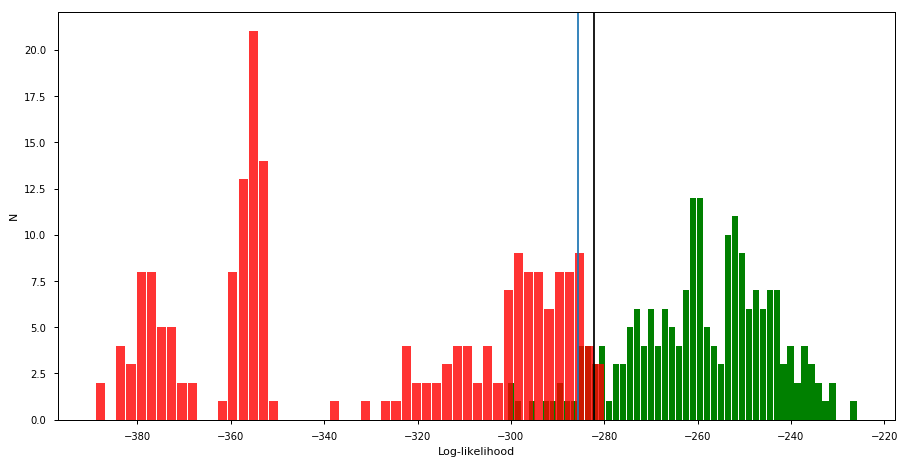

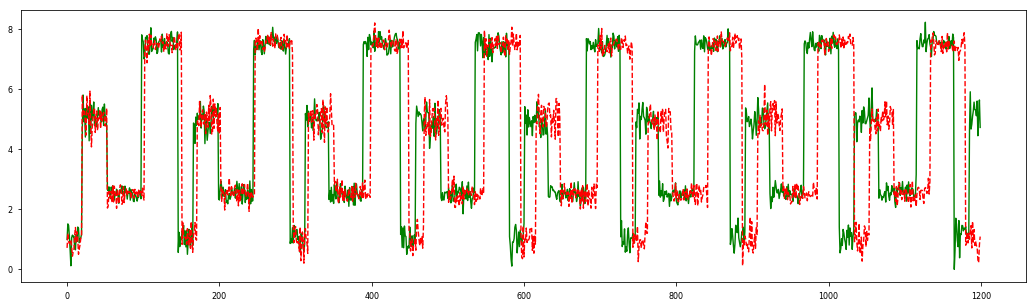

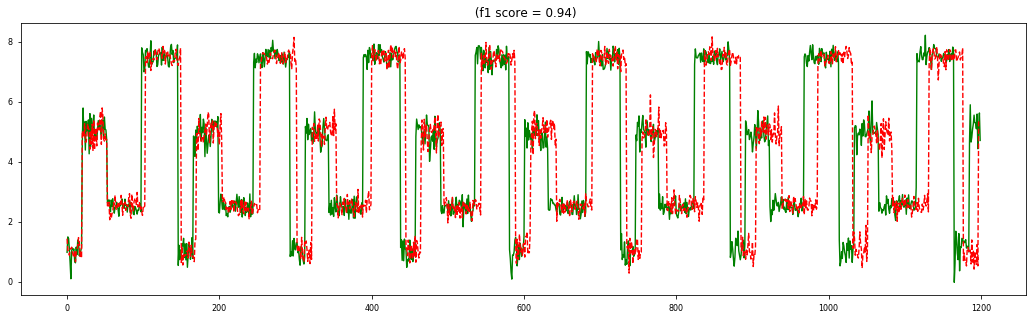

In [56]:
%%time
x_, y_,low_lvl = score(classifiear.models[0],x_test,y_true, classifiear.models[5].log_likelihood(signal[:T]), signal[:T], num_plot=1,lvl = 0.08,
               signal_for_lvl = signal_for_lvl, degree_std = 2)

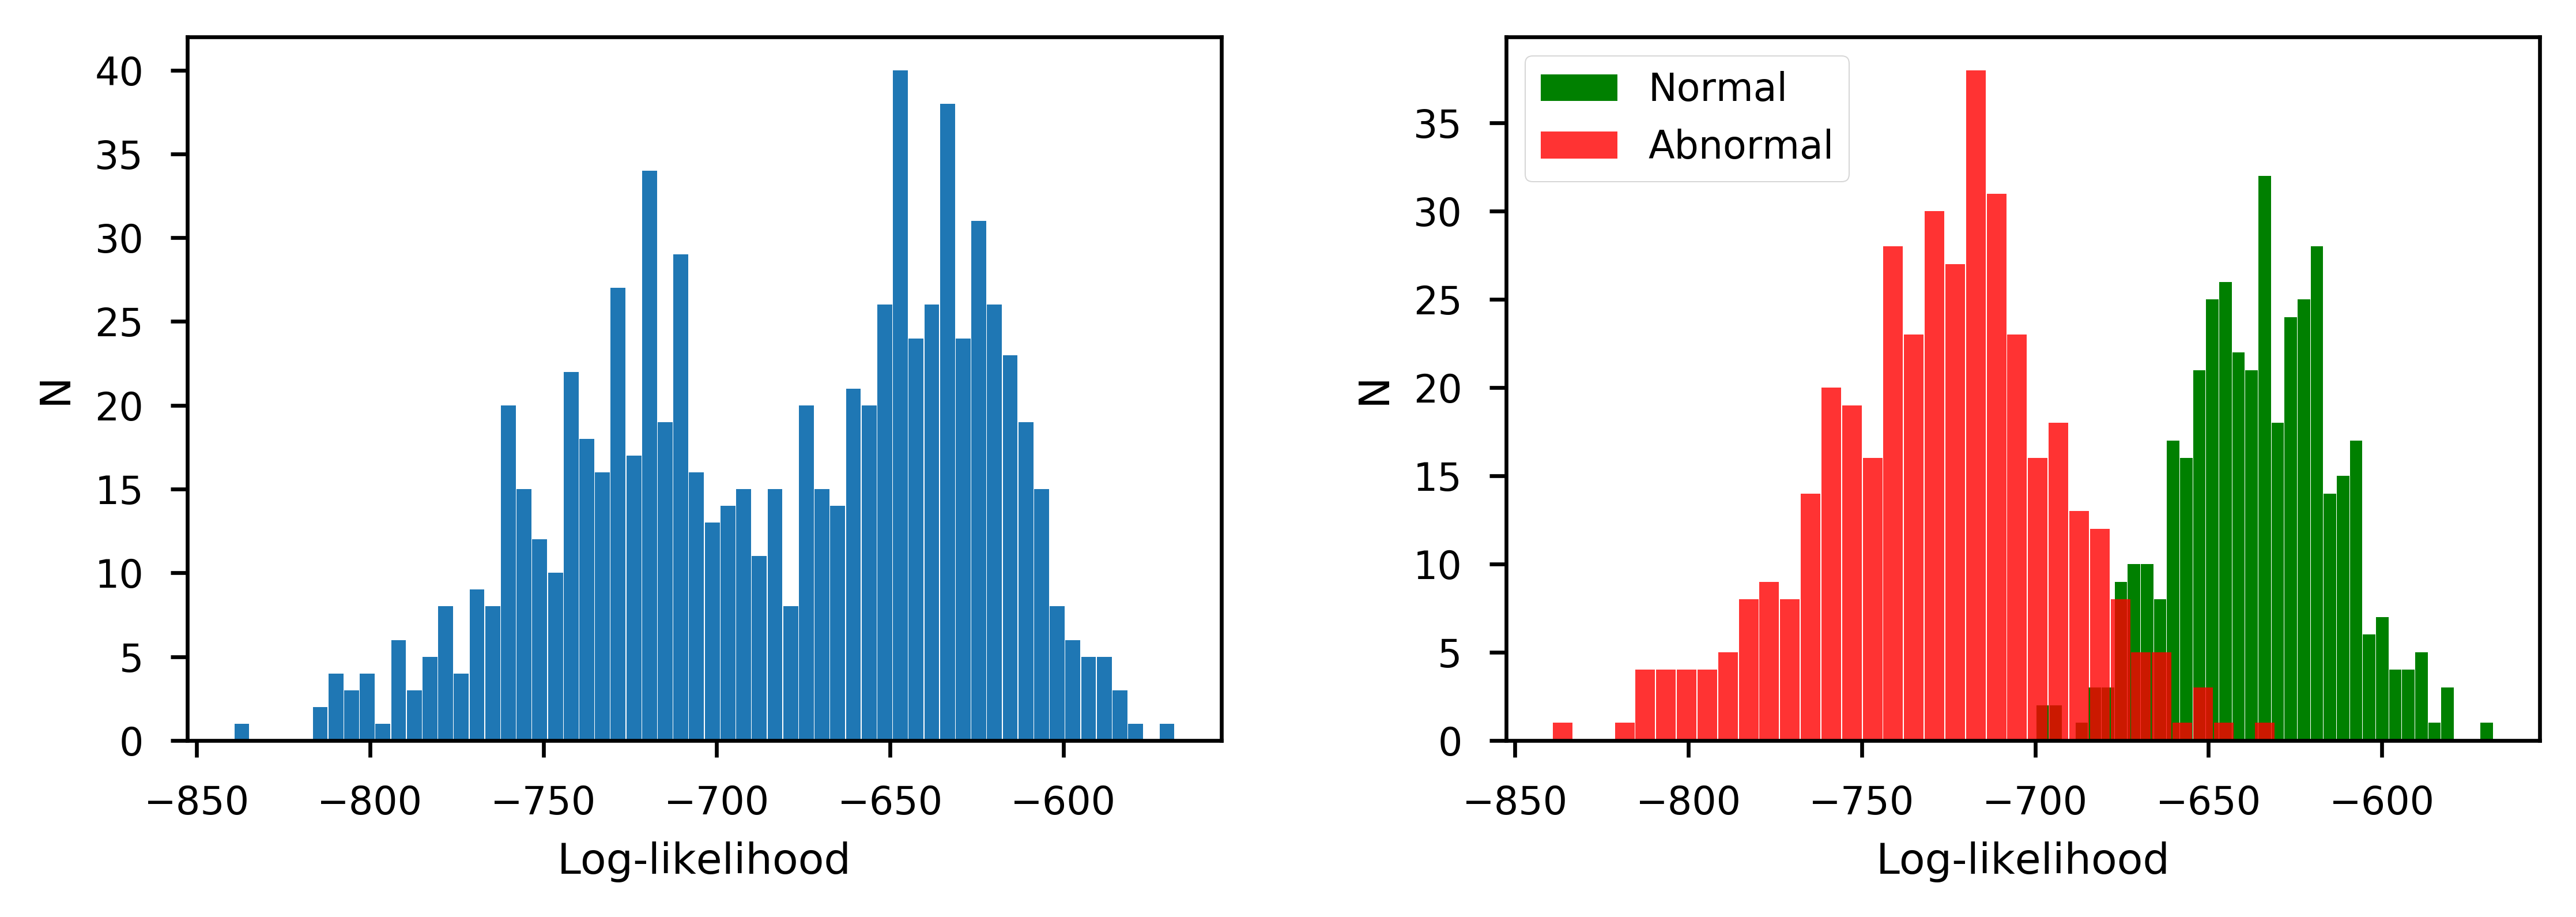

In [45]:
model_number = 1
fig = plt.figure(figsize=(8,3.2), dpi = 600,)
plt.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 25
plt.subplot(1,2,1)
plt.hist(ll[model_number], 60,rwidth = 0.95);
plt.ylabel('N')
plt.xlabel('Log-likelihood')
# plt.axvline(low_lvl,color='black',label='Threshold')


plt.subplot(1,2,2)
# plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
plt.hist(ll[model_number][y_true == 0],35,rwidth = 0.95, color='green',label='Normal');
# plt.axvline(x=classifiear.models[5].log_likelihood(signal[:T]))
# plt.axvline(low_lvl,color='black', label='Threshold')
plt.ylabel('N')
plt.xlabel('Log-likelihood')
#для аномальных
plt.hist(ll[model_number][y_true == 1],35,color = 'r',alpha = 0.8, rwidth = 0.95,label='Abnormal');

plt.legend()
plt.tight_layout()

plt.savefig('Гистограмма.tif', dpi = 300,quality=100);

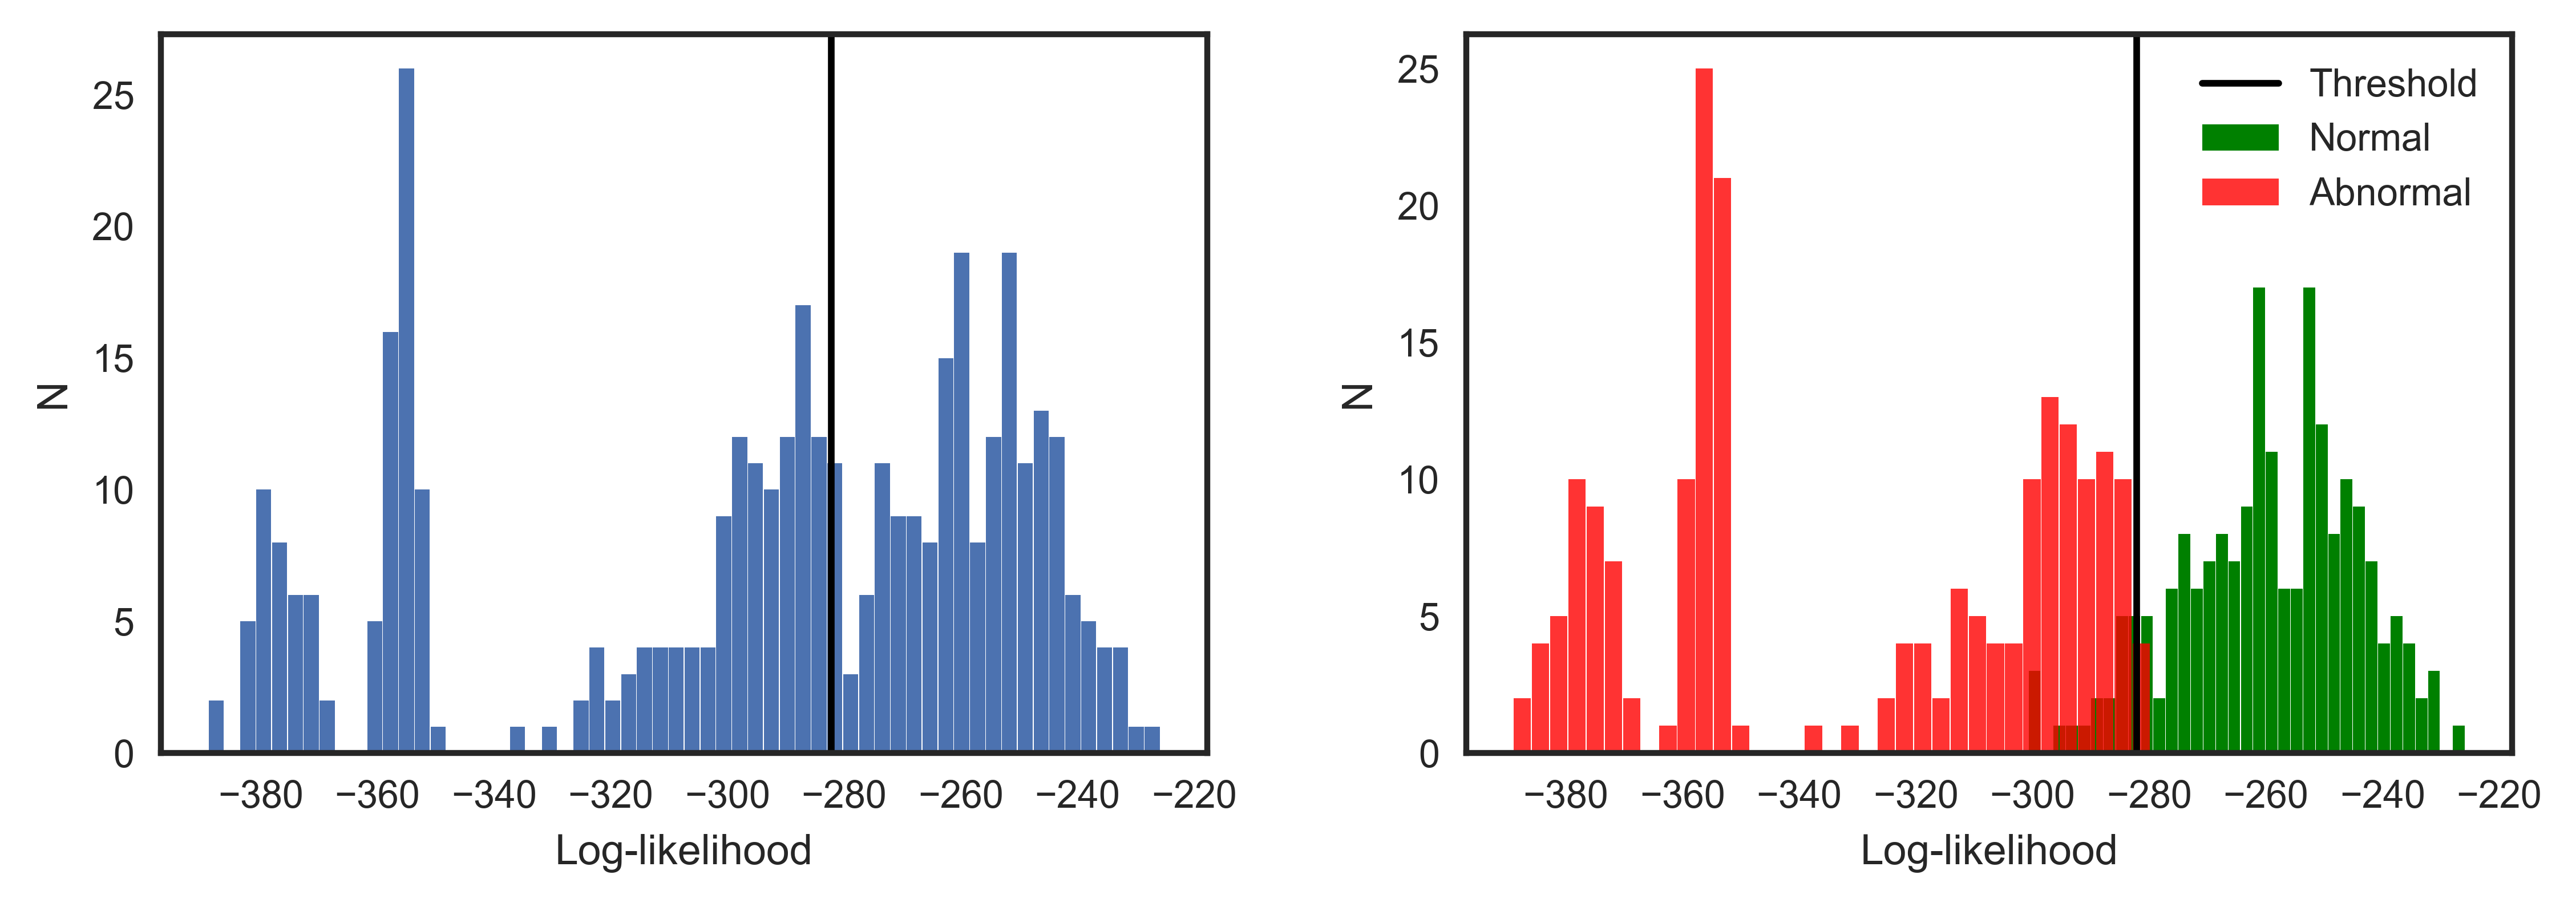

In [73]:
fig = plt.figure(figsize=(8,3.2), dpi = 600,)
plt.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 25
plt.subplot(1,2,1)
plt.hist(x_, 60,rwidth = 0.95);
plt.ylabel('N')
plt.xlabel('Log-likelihood')
plt.axvline(low_lvl,color='black',label='Threshold')


plt.subplot(1,2,2)
# plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
plt.hist(x_[y_true == 0],35,rwidth = 0.95, color='green',label='Normal');
# plt.axvline(x=classifiear.models[5].log_likelihood(signal[:T]))
plt.axvline(low_lvl,color='black', label='Threshold')
plt.ylabel('N')
plt.xlabel('Log-likelihood')
#для аномальных
plt.hist(x_[y_true == 1],35,color = 'r',alpha = 0.8, rwidth = 0.95,label='Abnormal');

plt.legend()
plt.tight_layout()

plt.savefig('Гистограмма.tif', dpi = 300,quality=100);


In [105]:
from matplotlib import pyplot as plt
%matplotlib inline
int(x_test.shape[0]/8)

50

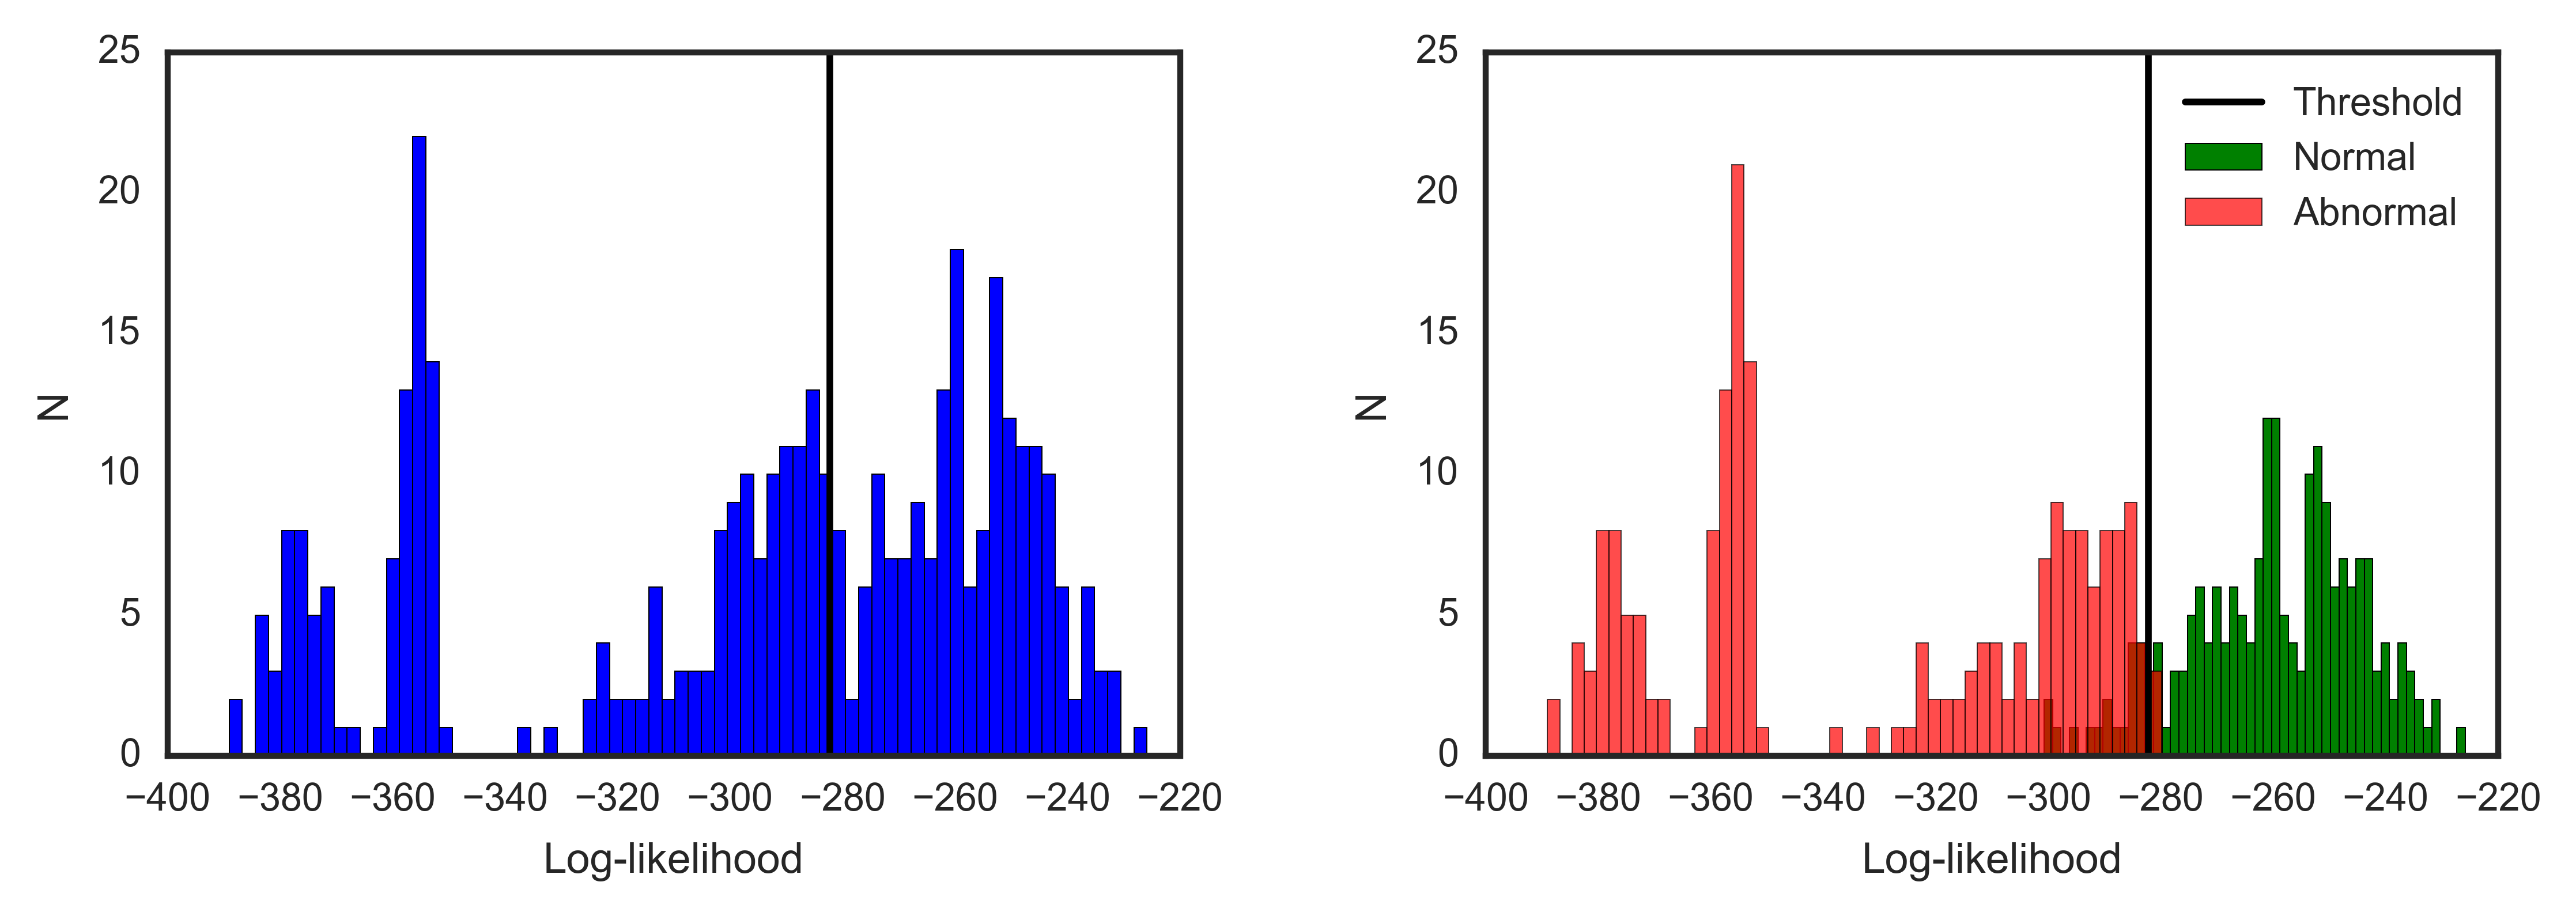

In [111]:
fig = plt.figure(figsize=(8,3.2), dpi = 600,)
plt.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 25
plt.subplot(1,2,1)
plt.hist(x_, 70,rwidth = 1, color = 'b');
plt.ylabel('N')
plt.xlabel('Log-likelihood')
plt.axvline(low_lvl,color='black',label='Threshold')


plt.subplot(1,2,2)
# plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
plt.hist(x_[y_true == 0],50,rwidth = 1, color='green',label='Normal');
# plt.axvline(x=classifiear.models[5].log_likelihood(signal[:T]))
plt.axvline(low_lvl,color='black', label='Threshold')
plt.ylabel('N')
plt.xlabel('Log-likelihood')
#для аномальных
plt.hist(x_[y_true == 1],50,color = 'r',alpha = 0.7, rwidth = 1,label='Abnormal');

plt.legend()
plt.tight_layout()

plt.savefig('Гистограмма.tif', dpi = 300,quality=100);


### Метрика F1, score ..

In [104]:
from sklearn.metrics import recall_score,accuracy_score,precision_score
print(f1_score(y_, y_true))
print(precision_score(y_, y_true))
print(recall_score(y_,y_true))


0.9448441247002398
0.985
0.9078341013824884


In [170]:
print(f1_score(y_, y_true))
print(precision_score(y_, y_true))
print(recall_score(y_,y_true))


0.9503916449086162
0.91
0.994535519125683


In [ ]:
plt.plot(x_test[260])
ll = np.array([hsmm.log_likelihood(np.array(x_test[260][:i]).reshape(-1,1)) if i > 5 else 0.0 
                                                            for i in range(len(x_test[0]))])
plt.plot(ll)

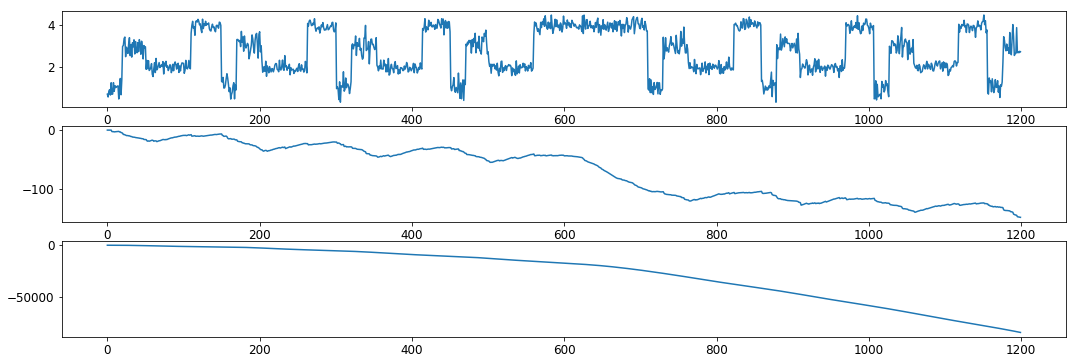

In [47]:
plt.subplot(3,1,1)
plt.plot(x_test[260])
plt.subplot(3,1,2)
plt.plot(ll)
plt.subplot(3,1,3)
# plt.plot(np.diff(ll,1))
plt.plot(np.cumsum(ll))

## Проверка инициализации разных моделей

In [41]:
%%time
signals = np.array(x_test)
for i,x in enumerate(signals):
    if i == 0:
        ll = classifiear.log_likelihood(x.reshape(-1,1))
    else:
        ll = np.vstack((ll, classifiear.log_likelihood(x.reshape(-1,1))))

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


CPU times: user 18min 3s, sys: 5.44 s, total: 18min 8s
Wall time: 18min 9s


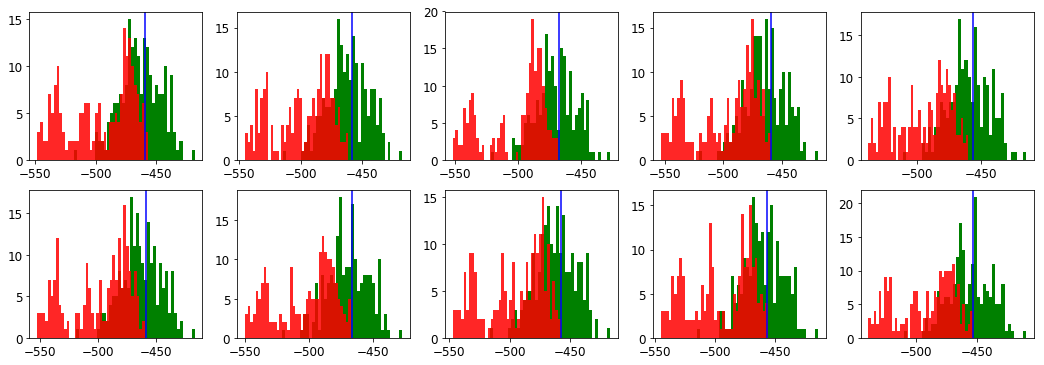

In [43]:
ll_normal = classifiear.log_likelihood(signal[:1200])
plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.hist(ll[:200,i],40, color = 'green')
    plt.hist(ll[200:,i],40, color = 'red', alpha = 0.85)
    plt.axvline(ll_normal[i],color='blue')

In [47]:
for m in classifiear.models:
    print(m.used_states)

[6, 4, 1]
[3, 6, 1]
[0, 2, 5]
[1, 5, 4]
[1, 4, 6]
[3, 2, 4]
[2, 3, 5]
[3, 4, 6]
[2, 0, 3]
[1, 5, 6]


### Оценка нижнего порога

In [ ]:
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import logistic

plt.hist(ll,10,color='r', normed=True);
mean, std = norm.fit(ll)
xx = np.linspace(mean - 5*std, mean + 5*std,200)
print(mean, std)
pdf = norm.pdf(xx,mean, std)
plt.plot(xx,pdf,color='black')

loc, scale = logistic.fit(ll)
laplace_pdf = logistic.pdf(xx,loc, scale)

plt.plot(xx, laplace_pdf,'green')
plt.axvline(mean - 3*std)

In [ ]:
ind = np.where((x_> - 525) & (y_true == 1))
fig = plt.figure(figsize=(20,40))
for i,x in enumerate(np.array(x_test)[ind]):
    plt.subplot(15,2,i+1,); i+=1
    plt.plot(signal[:T],'r')
    plt.plot(x)
    if i == 30:
        break

In [ ]:
fig = plt.figure(figsize=(20,4),dpi = 150)
plt.plot(x_, linewidth=2,)
plt.plot(range(len(x_)),[hsmm.log_likelihood(signal[:T])]*len(x_),'green', linewidth=2,label = 'Log-likelihood для обучения')
plt.xlabel('№ сигнала')
plt.ylabel('Log-likelihood')
plt.legend()
plt.savefig('log.jpeg',dpi = 150)

In [ ]:
states = hsmm.predict(np.array(x_test[150]).reshape(-1,1),1)[1]
plt.plot(np.array(x_test[150]))
plt.plot(states)

In [ ]:
np.array(x_test[0]).reshape(-1,1).shape

In [ ]:
%time z = [hsmm.log_likelihood(np.array(x_test[0]).reshape(-1,1))for i in range(100)]

In [ ]:
f1_score(y_true, y_)

In [ ]:
print(np.sum(y_[:100]))
ind = list(filter( lambda x: x< 100, np.where(y_ == 1)[0]))
print(ind)
i = 0
fig = plt.figure(figsize=(20,40))

for ll, x in zip(x_[ind], np.array(x_test)[ind]):
    plt.subplot(15,2,i+1,); i+=1
    plt.plot(x)
    plt.plot(signal[:T],'r')
    plt.title('{}'.format(ll))
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [ ]:
ind = list(filter( lambda x: x> 100, np.where(y_ == 0)[0]))
print(ind)
i = 0
fig = plt.figure(figsize=(20,40))

for x in np.array(x_test)[ind]:
    plt.subplot(15,2,i+1,); i+=1
    plt.plot(x)
    if i == 30:
        break
plt.show()

In [ ]:
signals = []
for i in range(1000):
    signals+=[signal_manager.generators[0].generate_signal()[:T]]
signals = np.array(signals)
ll = np.zeros((1000,))
for k, x in enumerate(signals):
    ll[k] = hsmm.log_likelihood(x.reshape(-1,1))

In [ ]:
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import logistic

plt.hist(ll,30,color='r', normed=True);
mean, std = norm.fit(ll)
xx = np.linspace(mean - 5*std, mean + 5*std,200)
print(mean, std)
pdf = norm.pdf(xx,mean, std)
plt.plot(xx,pdf,color='black')

loc, scale = logistic.fit(ll)
laplace_pdf = logistic.pdf(xx,loc, scale)

plt.plot(xx, laplace_pdf,'green')

In [ ]:
fig = plt.figure(figsize=(20,80))
for i in range(20):
    ax = plt.subplot(20, 1, i+1)
    plt.plot(signal,'g')
    plt.plot(anomals[np.where(log_scores>-240)[0][i]],'r--')
# plt.tight_layout()
plt.savefig('Сравнение аномальный сигналов с нормальным.jpeg',dpi = 80)

In [ ]:
fig = plt.figure(figsize=(20,80))
for i in range(20):
    ax = plt.subplot(20, 1, i+1)
    plt.plot(signal,'g')
    plt.plot(anomals[np.where(log_scores<-240)[0][i]],'r--')
# plt.tight_layout()
plt.savefig('Сравнение аномальный сигналов с нормальным более аномальные.jpeg',dpi = 80)

In [ ]:
models = [ create_model(signal,7) for i in range(5)]

In [ ]:
for model in models:
    print(' ll = ', model.log_likelihood(signal))

##Аномал скор нарастающий

In [ ]:
def compute_anomal_score(model, seq):
    if isinstance(seq, list):
        seq = np.array(seq)
        seq = seq.reshape(-1,1)
    b = np.zeros((seq.shape[0],))
  
    for i in range(seq.shape[0]):
        if i == 0:
            continue
        b[i] = model.log_likelihood(seq[:i])
    return -b.sum()/len(b), b 

In [6]:
def duration_prod(d,a):
    return a**(d-1)*(1-a) 

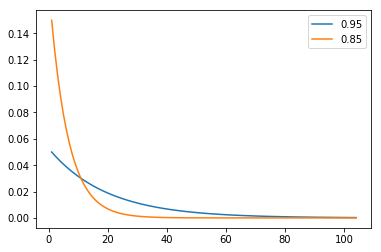

In [36]:
d = np.arange(1,105,1)
a = 0.95
p = duration_prod(d,a)
plt.plot(d,p,label = str(a))
a = 0.85
p1 = duration_prod(d,a)
plt.plot(d,p1,label = str(a))
plt.legend()

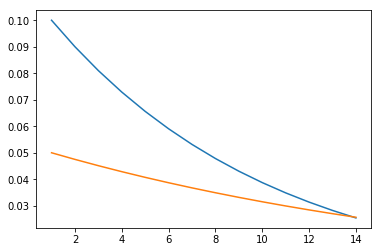

In [23]:
plt.plot(d,p,label = str(a))
plt.plot(d,p1)